[View in Colaboratory](https://colab.research.google.com/github/buddharajuramaraju/Census-bureau-database-Project/blob/master/Census_bureau_database_Project.ipynb)

Problem 1:
Prediction task is to determine whether a person makes over 50K a year.

Problem 2:
Which factors are important

Problem 3:
Which algorithms are best for this dataset

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score,roc_auc_score
import xgboost as xgb

from matplotlib import pyplot as pt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV

sns.set(color_codes=True)
% matplotlib inline

#####  Loading data

In [2]:
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)
test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test' , skiprows = 1, header = None)

#####  Add columns labels

In [3]:
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation','relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'wage_class']

In [4]:
train_set.columns = col_labels 
test_set.columns = col_labels

#####  Train data header

In [5]:
train_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


##### Test data header

In [6]:
test_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


### Data Cleaning


##### Step1 : Removing rows contains '?'

In [7]:
train_set=train_set.replace(regex='\?',value=pd.np.nan).dropna(how='any')
train_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Transformation of data

##### column : hours_per_week

count    30162.000000
mean        40.931238
std         11.979984
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours_per_week, dtype: float64

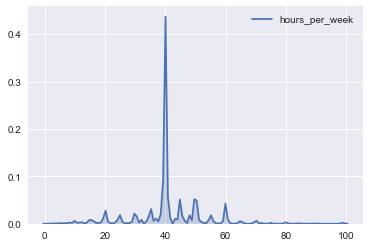

In [8]:
sns.kdeplot(train_set.hours_per_week,shade=True)
train_set.hours_per_week.describe()

As per above summary and plot we understood that most of the people working 40 to 45 hours
therefore, we will group hours_per_week into 5 relavent groups as below
###### group 1: less_than_40
###### group 2: between_40_to_45
###### group 3 :between_45_to_60
###### group 4 :between_60_to_80
###### group 5 :more_than_80

In [9]:
train_set.hours_per_week=train_set.hours_per_week.astype(int)
train_set.loc[train_set.hours_per_week < 40,'hours_per_week_group'] = 'less_than_40'
train_set.loc[(train_set.hours_per_week >= 40) & (train_set.hours_per_week <= 45),'hours_per_week_group'] = 'between_40_to_45'
train_set.loc[(train_set.hours_per_week > 45) & (train_set.hours_per_week <= 60),'hours_per_week_group'] = 'between_45_to_60'
train_set.loc[(train_set.hours_per_week > 60) & (train_set.hours_per_week <= 80),'hours_per_week_group'] = 'between_60_to_80'
train_set.loc[train_set.hours_per_week > 80,'hours_per_week_group'] = 'more_than_40'

In [10]:
train_set['hours_per_week_group'].head()

0    between_40_to_45
1        less_than_40
2    between_40_to_45
3    between_40_to_45
4    between_40_to_45
Name: hours_per_week_group, dtype: object

##### column:native_country

In [11]:
train_set.native_country.unique()


array([' United-States', ' Cuba', ' Jamaica', ' India', ' Mexico',
       ' Puerto-Rico', ' Honduras', ' England', ' Canada', ' Germany',
       ' Iran', ' Philippines', ' Poland', ' Columbia', ' Cambodia',
       ' Thailand', ' Ecuador', ' Laos', ' Taiwan', ' Haiti', ' Portugal',
       ' Dominican-Republic', ' El-Salvador', ' France', ' Guatemala',
       ' Italy', ' China', ' South', ' Japan', ' Yugoslavia', ' Peru',
       ' Outlying-US(Guam-USVI-etc)', ' Scotland', ' Trinadad&Tobago',
       ' Greece', ' Nicaragua', ' Vietnam', ' Hong', ' Ireland',
       ' Hungary', ' Holand-Netherlands'], dtype=object)

In [12]:
len(train_set.native_country.unique())

41

categorical variable named native_county has 41 unique values, if we use directly this column for training it might lead to overfitting, therefore thransforming native_county into native_region

In [13]:
Asia_East = np.array([" Cambodia", " China", " Hong", " Laos", " Thailand"," Japan", " Taiwan", " Vietnam"," Philippines"])
Asia_Central = np.array([" India", " Iran"])
Central_America =  np.array([" Cuba", " Guatemala", " Jamaica", " Nicaragua"," Puerto-Rico",  " Dominican-Republic", " El-Salvador"," Haiti", " Honduras", " Mexico", " Trinadad&Tobago"])
South_America = np.array([" Ecuador", " Peru", " Columbia"," South"])
Europe_West = np.array([" England", " Germany", " Holand-Netherlands", " Ireland"," France", " Greece", " Italy", " Portugal", " Scotland"])
Europe_East = np.array([" Poland", " Yugoslavia", " Hungary"])
North_America = np.array([" Outlying-US(Guam-USVI-etc)", " United-States"," Canada"])

In [14]:
train_set.loc[train_set.native_country.isin(Asia_East),'native_region'] = 'Asia_East'
train_set.loc[train_set.native_country.isin(Asia_Central),'native_region'] = 'Asia_Central'
train_set.loc[train_set.native_country.isin(Central_America),'native_region'] = 'Central_America'
train_set.loc[train_set.native_country.isin(South_America),'native_region'] = 'South_America'
train_set.loc[train_set.native_country.isin(Europe_West),'native_region'] = 'Europe_West'
train_set.loc[train_set.native_country.isin(Europe_East),'native_region'] = 'Europe_East'
train_set.loc[train_set.native_country.isin(North_America),'native_region'] = 'North_America'

In [15]:
train_set.native_region.unique()


array(['North_America', 'Central_America', 'Asia_Central', 'Europe_West',
       'Asia_East', 'Europe_East', 'South_America'], dtype=object)

##### column : capital_gain & capital_loss

count    30162.000000
mean      1092.007858
std       7406.346497
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital_gain, dtype: float64

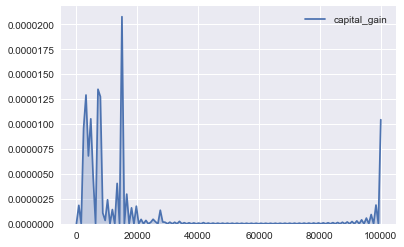

In [16]:
sns.kdeplot(train_set.capital_gain,shade=True)
train_set.capital_gain.describe()

count    30162.000000
mean        88.372489
std        404.298370
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: capital_loss, dtype: float64

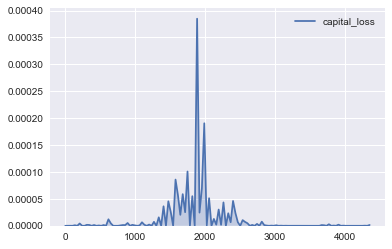

In [17]:
sns.kdeplot(train_set.capital_loss,shade=True)
train_set.capital_loss.describe()

As per above summary and plots, we understood that most of the values of capital_gain & capital_loss are zeros, therefore we are replacing 0 with mean of columns to avoid overfitting

In [18]:
capital_gain_mean = train_set.capital_gain.mean()
capital_loss_mean = train_set.capital_loss.mean()


In [19]:
train_set.loc[train_set.capital_gain == 0 ,'capital_gain'] = capital_gain_mean
train_set.loc[train_set.capital_loss == 0 ,'capital_loss'] = capital_loss_mean

In [20]:
train_set.capital_gain.describe()

count    30162.000000
mean      2092.128044
std       7263.712520
min        114.000000
25%       1092.007858
50%       1092.007858
75%       1092.007858
max      99999.000000
Name: capital_gain, dtype: float64

In [21]:
train_set.capital_loss.describe()


count    30162.000000
mean       172.563970
std        385.912263
min         88.372489
25%         88.372489
50%         88.372489
75%         88.372489
max       4356.000000
Name: capital_loss, dtype: float64

##### column : work class : No Change required

In [22]:
train_set.workclass.describe()

count        30162
unique           7
top        Private
freq         22286
Name: workclass, dtype: object

In [23]:
train_set.workclass.unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' Self-emp-inc', ' Without-pay'], dtype=object)

##### Convert categorical variables into numerical format
eduction and education_num are duplicate values

In [24]:
workclass = pd.factorize(train_set.workclass)
education = pd.factorize(train_set.education)
hours_per_week_group = pd.factorize(train_set.hours_per_week_group) ## Tacking grouping 
marital_status = pd.factorize(train_set.marital_status)
occupation = pd.factorize(train_set.occupation)
relationship = pd.factorize(train_set.relationship)
race = pd.factorize(train_set.race)
sex = pd.factorize(train_set.sex)
native_region = pd.factorize(train_set.native_region) ## Tacking region
wage_class = pd.factorize(train_set.wage_class)


In [25]:
X_train = pd.DataFrame({'age':train_set.age,'workclass':workclass[0],'fnlwgt':train_set.fnlwgt,'education':education[0],'hours_per_week_group':hours_per_week_group[0],'marital_status':marital_status[0],'occupation':occupation[0],'relationship':relationship[0],'race':race[0],'sex':sex[0],'capital_gain':train_set.capital_gain,'capital_loss':train_set.capital_loss,'hours_per_week_group':hours_per_week_group[0],'native_region':native_region[0]})
Y_train = wage_class[0]
X_train.head()

,age,capital_gain,capital_loss,education,fnlwgt,hours_per_week_group,marital_status,native_region,occupation,race,relationship,sex,workclass
0,39,2174.000000,88.372489,0,77516,0,0,0,0,0,0,0,0
1,50,1092.007858,88.372489,0,83311,1,1,0,1,0,1,0,1
2,38,1092.007858,88.372489,1,215646,0,2,0,2,0,0,0,2
3,53,1092.007858,88.372489,2,234721,0,1,0,2,1,1,0,2
4,28,1092.007858,88.372489,0,338409,0,1,1,3,1,2,1,2


##### Clean test data : we are following the same steps followed for Train data

In [26]:
test_set=test_set.replace(regex='\?',value=pd.np.nan).dropna(how='any') ## removing ?
test_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K.


##### column : hours_per_week

In [27]:
test_set.hours_per_week=test_set.hours_per_week.astype(int)
test_set.loc[test_set.hours_per_week < 40,'hours_per_week_group'] = 'less_than_40'
test_set.loc[(test_set.hours_per_week >= 40) & (test_set.hours_per_week <= 45),'hours_per_week_group'] = 'between_40_to_45'
test_set.loc[(test_set.hours_per_week > 45) & (test_set.hours_per_week <= 60),'hours_per_week_group'] = 'between_45_to_60'
test_set.loc[(test_set.hours_per_week > 60) & (test_set.hours_per_week <= 80),'hours_per_week_group'] = 'between_60_to_80'
test_set.loc[test_set.hours_per_week > 80,'hours_per_week_group'] = 'more_than_40'

##### column:native_country

In [28]:
test_set.loc[test_set.native_country.isin(Asia_East),'native_region'] = 'Asia_East'
test_set.loc[test_set.native_country.isin(Asia_Central),'native_region'] = 'Asia_Central'
test_set.loc[test_set.native_country.isin(Central_America),'native_region'] = 'Central_America'
test_set.loc[test_set.native_country.isin(South_America),'native_region'] = 'South_America'
test_set.loc[test_set.native_country.isin(Europe_West),'native_region'] = 'Europe_West'
test_set.loc[test_set.native_country.isin(Europe_East),'native_region'] = 'Europe_East'
test_set.loc[test_set.native_country.isin(North_America),'native_region'] = 'North_America'

In [29]:
test_set.native_region.unique()

array(['North_America', 'South_America', 'Central_America', 'Europe_West',
       'Asia_East', 'Asia_Central', 'Europe_East'], dtype=object)

##### column : capital_gain & capital_loss

In [30]:
capital_gain_mean = test_set.capital_gain.mean()
capital_loss_mean = test_set.capital_loss.mean()

In [31]:
test_set.loc[test_set.capital_gain == 0 ,'capital_gain'] = capital_gain_mean
test_set.loc[test_set.capital_loss == 0 ,'capital_loss'] = capital_loss_mean

In [32]:
test_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class,hours_per_week_group,native_region
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,1120.301594,89.041899,40,United-States,<=50K.,between_40_to_45,North_America
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,1120.301594,89.041899,50,United-States,<=50K.,between_45_to_60,North_America
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,1120.301594,89.041899,40,United-States,>50K.,between_40_to_45,North_America
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.000000,89.041899,40,United-States,>50K.,between_40_to_45,North_America
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,1120.301594,89.041899,30,United-States,<=50K.,less_than_40,North_America


##### Cleaning test wage_class

In [33]:
test_set.wage_class.head()

0     <=50K.
1     <=50K.
2      >50K.
3      >50K.
5     <=50K.
Name: wage_class, dtype: object

##### removing extra '.'

In [34]:
test_set.loc[test_set.wage_class == ' <=50K.' ,'wage_class'] = ' <=50K'
test_set.loc[test_set.wage_class == ' >50K.' ,'wage_class'] = ' >50K'
test_set.wage_class.head()

0     <=50K
1     <=50K
2      >50K
3      >50K
5     <=50K
Name: wage_class, dtype: object

##### Convert categorical variables into numerical format
eduction and education_num are duplicate values

In [35]:
workclass = pd.factorize(test_set.workclass)
education = pd.factorize(test_set.education)
hours_per_week_group = pd.factorize(test_set.hours_per_week_group) ## Tacking grouping 
marital_status = pd.factorize(test_set.marital_status)
occupation = pd.factorize(test_set.occupation)
relationship = pd.factorize(test_set.relationship)
race = pd.factorize(test_set.race)
sex = pd.factorize(test_set.sex)
native_region = pd.factorize(test_set.native_region) ## Tacking region
wage_class = pd.factorize(test_set.wage_class)

In [36]:
X_test = pd.DataFrame({'age':test_set.age,'workclass':workclass[0],'fnlwgt':test_set.fnlwgt,'education':education[0],'hours_per_week_group':hours_per_week_group[0],'marital_status':marital_status[0],'occupation':occupation[0],'relationship':relationship[0],'race':race[0],'sex':sex[0],'capital_gain':test_set.capital_gain,'capital_loss':test_set.capital_loss,'hours_per_week_group':hours_per_week_group[0],'native_region':native_region[0]})
Y_test = wage_class[0]
X_test.head()

,age,capital_gain,capital_loss,education,fnlwgt,hours_per_week_group,marital_status,native_region,occupation,race,relationship,sex,workclass
0,25,1120.301594,89.041899,0,226802,0,0,0,0,0,0,0,0
1,38,1120.301594,89.041899,1,89814,1,1,0,1,1,1,0,0
2,28,1120.301594,89.041899,2,336951,0,1,0,2,1,1,0,1
3,44,7688.000000,89.041899,3,160323,0,1,0,0,0,1,0,0
5,34,1120.301594,89.041899,4,198693,2,0,0,3,1,2,0,0


##### Train Model & Test

## Alg : XGBoost

### Step1:Tuning Tree Based Parameters

C:\Users\Ramaraju\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy : 0.804
AUC Score (Train): 0.791421


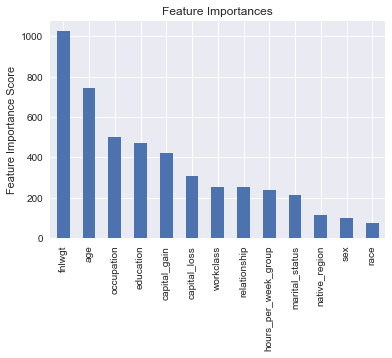

In [37]:
model = xgb.XGBClassifier(learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

xgb_param = model.get_xgb_params()
dtrain = xgb.DMatrix(data=X_train,label=Y_train)

## To Get CV Result
cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=model.get_params()['n_estimators'], nfold=5,
            metrics='auc', early_stopping_rounds=50)

## Set CV Result
model.set_params(n_estimators=cvresult.shape[0])

## Fit Model
model.fit(X_train, Y_train)

## Predict 
Y_pred=model.predict(X_test)
pred_prob = model.predict_proba(X_test)[:,1]

print ("Accuracy : %.4g" % accuracy_score(Y_test, Y_pred))
print ("AUC Score (Train): %f" % roc_auc_score(Y_test, pred_prob))


feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
pt.ylabel('Feature Importance Score')
pt.show()

### Step2:Tune max_depth and min_child_weight


In [38]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = model, param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, Y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\Ramaraju\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.92183, std: 0.00303, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.92131, std: 0.00331, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.92118, std: 0.00286, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.92473, std: 0.00291, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.92457, std: 0.00288, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.92401, std: 0.00289, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.92409, std: 0.00238, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.92324, std: 0.00283, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.92283, std: 0.00295, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.92096, std: 0.00302, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.92088, std: 0.00308, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.92055, std: 0.00328, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 1

##### The ideal values are  5 for max_depth & 1 for min_child_weight , Lets go one step deeper and look for optimum values, we one above and below of optimum values because we took an interval of 2

In [39]:
param_test1 = {
 'max_depth':[4,5,6],
 'min_child_weight':[1,2]
}

gsearch1 = GridSearchCV(estimator = model, param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, Y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_


C:\Users\Ramaraju\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.92478, std: 0.00278, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.92445, std: 0.00281, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.92473, std: 0.00291, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.92503, std: 0.00312, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.92480, std: 0.00292, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: 0.92424, std: 0.00264, params: {'max_depth': 6, 'min_child_weight': 2}],
 {'max_depth': 5, 'min_child_weight': 2},
 0.9250289955174331)

#### Test Model with 'max_depth': 5, 'min_child_weight': 2

C:\Users\Ramaraju\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy : 0.8049
AUC Score (Test): 0.788312


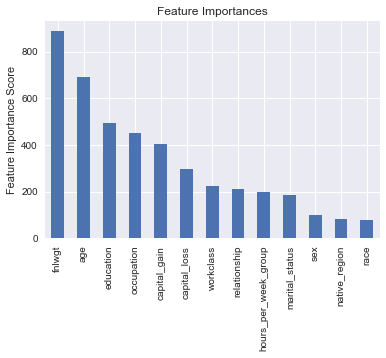

In [40]:
model = xgb.XGBClassifier(learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

xgb_param = model.get_xgb_params()
dtrain = xgb.DMatrix(data=X_train,label=Y_train)

## To Get CV Result
cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=model.get_params()['n_estimators'], nfold=5,
            metrics='auc', early_stopping_rounds=50)

## Set CV Result
model.set_params(n_estimators=cvresult.shape[0])

## Fit Model
model.fit(X_train, Y_train)

## Predict 
Y_pred=model.predict(X_test)
pred_prob = model.predict_proba(X_test)[:,1]

print ("Accuracy : %.4g" % accuracy_score(Y_test, Y_pred))
print ("AUC Score (Test): %f" % roc_auc_score(Y_test, pred_prob))


feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
pt.ylabel('Feature Importance Score')
pt.show()

### Step3:Tune Gamma

In [41]:
param_test1 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch1 = GridSearchCV(estimator = model, param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, Y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\Ramaraju\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.92496, std: 0.00314, params: {'gamma': 0.0},
  mean: 0.92493, std: 0.00278, params: {'gamma': 0.1},
  mean: 0.92454, std: 0.00262, params: {'gamma': 0.2},
  mean: 0.92484, std: 0.00305, params: {'gamma': 0.3},
  mean: 0.92445, std: 0.00277, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.9249571569931729)

##### Optimum value for gamma is 0

### Step4:Tune subsample and colsample_bytree

In [42]:
param_test1 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch1 = GridSearchCV(estimator = model, param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, Y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_


C:\Users\Ramaraju\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.92455, std: 0.00244, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.92481, std: 0.00266, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.92576, std: 0.00275, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.92606, std: 0.00258, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.92384, std: 0.00255, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.92486, std: 0.00268, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.92501, std: 0.00287, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.92559, std: 0.00251, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.92379, std: 0.00250, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.92434, std: 0.00290, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.92496, std: 0.00314, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.92533, std: 0.00281, params: {'colsample_bytree': 0.8, 'subsample'

In [43]:
param_test1 = {
 'subsample':[i/100 for i in range(55,70,5)],
 'colsample_bytree':[i/100 for i in range(85,100,5)]
}

gsearch1 = GridSearchCV(estimator = model, param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, Y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\Ramaraju\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.92300, std: 0.00253, params: {'colsample_bytree': 0.85, 'subsample': 0.55},
  mean: 0.92344, std: 0.00266, params: {'colsample_bytree': 0.85, 'subsample': 0.6},
  mean: 0.92387, std: 0.00251, params: {'colsample_bytree': 0.85, 'subsample': 0.65},
  mean: 0.92300, std: 0.00253, params: {'colsample_bytree': 0.9, 'subsample': 0.55},
  mean: 0.92344, std: 0.00266, params: {'colsample_bytree': 0.9, 'subsample': 0.6},
  mean: 0.92387, std: 0.00251, params: {'colsample_bytree': 0.9, 'subsample': 0.65},
  mean: 0.92247, std: 0.00239, params: {'colsample_bytree': 0.95, 'subsample': 0.55},
  mean: 0.92330, std: 0.00271, params: {'colsample_bytree': 0.95, 'subsample': 0.6},
  mean: 0.92363, std: 0.00268, params: {'colsample_bytree': 0.95, 'subsample': 0.65}],
 {'colsample_bytree': 0.85, 'subsample': 0.65},
 0.9238735239844951)

#### Optimum values of  colsample_bytree is 0.85 and subsample is 0.65

C:\Users\Ramaraju\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy : 0.8064
AUC Score (Test): 0.794831


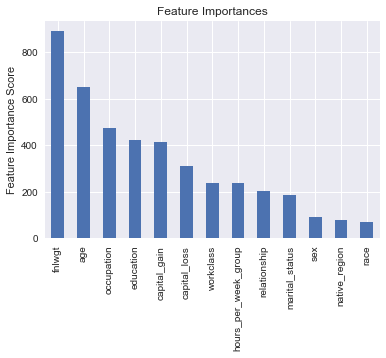

In [44]:
model = xgb.XGBClassifier(learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0,
 subsample=0.85,
 colsample_bytree=0.85,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

xgb_param = model.get_xgb_params()
dtrain = xgb.DMatrix(data=X_train,label=Y_train)

## To Get CV Result
cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=model.get_params()['n_estimators'], nfold=5,
            metrics='auc', early_stopping_rounds=50)

## Set CV Result
model.set_params(n_estimators=cvresult.shape[0])

## Fit Model
model.fit(X_train, Y_train)

## Predict 
Y_pred=model.predict(X_test)
pred_prob = model.predict_proba(X_test)[:,1]

print ("Accuracy : %.4g" % accuracy_score(Y_test, Y_pred))
print ("AUC Score (Test): %f" % roc_auc_score(Y_test, pred_prob))


feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
pt.ylabel('Feature Importance Score')
pt.show()

### Step5:  Tuning Regularization Parameters

In [45]:
param_test1 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch1 = GridSearchCV(estimator = model, param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, Y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\Ramaraju\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.92509, std: 0.00264, params: {'reg_alpha': 1e-05},
  mean: 0.92510, std: 0.00283, params: {'reg_alpha': 0.01},
  mean: 0.92527, std: 0.00278, params: {'reg_alpha': 0.1},
  mean: 0.92463, std: 0.00290, params: {'reg_alpha': 1},
  mean: 0.90193, std: 0.00339, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.1},
 0.9252695042370309)

In [46]:
param_test1 = {
'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

gsearch1 = GridSearchCV(estimator = model, param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, Y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\Ramaraju\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.92509, std: 0.00264, params: {'reg_alpha': 0},
  mean: 0.92512, std: 0.00269, params: {'reg_alpha': 0.001},
  mean: 0.92522, std: 0.00271, params: {'reg_alpha': 0.005},
  mean: 0.92510, std: 0.00283, params: {'reg_alpha': 0.01},
  mean: 0.92512, std: 0.00260, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0.005},
 0.9252209627927434)

### Step6: Reducing Learning Rate

C:\Users\Ramaraju\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy : 0.805
AUC Score (Test): 0.789635


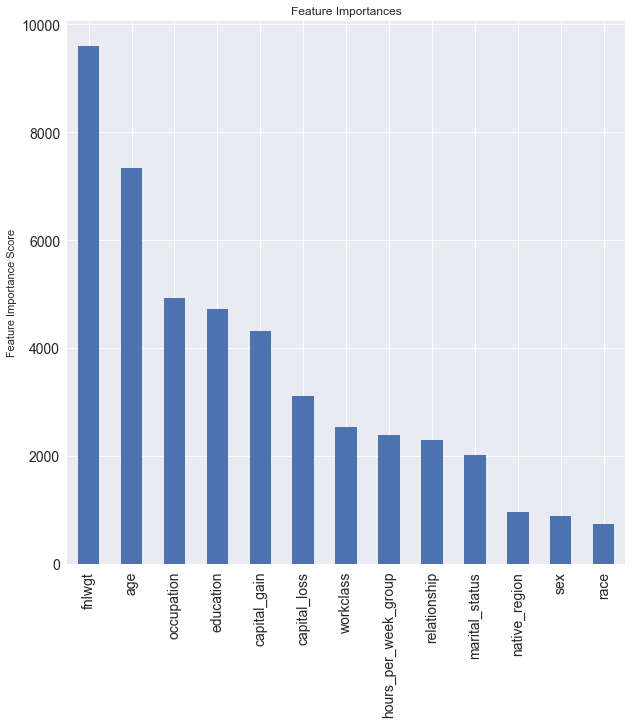

In [47]:
model = xgb.XGBClassifier(learning_rate =0.01,
 n_estimators=5000,
 reg_alpha= 0.001,
 max_depth=5,
 min_child_weight=2,
 gamma=0,
 subsample=0.85,
 colsample_bytree=0.85,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

xgb_param = model.get_xgb_params()
dtrain = xgb.DMatrix(data=X_train,label=Y_train)

## To Get CV Result
cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=model.get_params()['n_estimators'], nfold=5,
            metrics='auc', early_stopping_rounds=50)

## Set CV Result
model.set_params(n_estimators=cvresult.shape[0])

## Fit Model
model.fit(X_train, Y_train)

## Predict 
Y_pred=model.predict(X_test)
pred_prob = model.predict_proba(X_test)[:,1]

print ("Accuracy : %.4g" % accuracy_score(Y_test, Y_pred))
print ("AUC Score (Test): %f" % roc_auc_score(Y_test, pred_prob))


feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances',figsize=(10,10),fontsize=14)
pt.ylabel('Feature Importance Score')
pt.show()

## Alg:Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [49]:
lr.fit(X_train,Y_train)
Y_pred = lr.predict(X_test)
print ("Accuracy : %.4g" % accuracy_score(Y_test, Y_pred))


Accuracy : 0.7913


## Alg:Naïve Bayes

In [50]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
GNB

GaussianNB(priors=None)

In [51]:
GNB.fit(X_train,Y_train)
Y_pred = GNB.predict(X_test)
print ("Accuracy : %.4g" % accuracy_score(Y_test, Y_pred))

Accuracy : 0.7905


## Alg: Stochastic Gradient Descent

In [52]:
from sklearn.linear_model import SGDClassifier
SGD = SGDClassifier(loss='modified_huber',shuffle=True,random_state=101)
SGD

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=None, n_jobs=1, penalty='l2', power_t=0.5, random_state=101,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [53]:
SGD.fit(X_train,Y_train)
Y_pred = SGD.predict(X_test)
print ("Accuracy : %.4g" % accuracy_score(Y_test, Y_pred))

Accuracy : 0.6793


C:\Users\Ramaraju\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


## Alg:K-Nearest Neighbours

In [54]:
from sklearn.neighbors import KNeighborsClassifier
KNC = KNeighborsClassifier(n_neighbors = 10,leaf_size=20)
KNC

KNeighborsClassifier(algorithm='auto', leaf_size=20, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [55]:
KNC.fit(X_train,Y_train)
Y_pred = KNC.predict(X_test)
print ("Accuracy : %.4g" % accuracy_score(Y_test, Y_pred))

Accuracy : 0.7897


## Alg:  Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DC = DecisionTreeClassifier(max_depth=30, max_features=8, max_leaf_nodes=95,random_state=105)
DC

In [ ]:
DC.fit(X_train,Y_train)
Y_pred = DC.predict(X_test)
print ("Accuracy : %.4g" % accuracy_score(Y_test, Y_pred))

## Alg:Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators=5000,max_depth=30, max_features=8, max_leaf_nodes=95,random_state=105)
RFC

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=8, max_leaf_nodes=95,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=1,
            oob_score=False, random_state=105, verbose=0, warm_start=False)

In [59]:
RFC.fit(X_train,Y_train)
Y_pred = RFC.predict(X_test)
print ("Accuracy : %.4g" % accuracy_score(Y_test, Y_pred))

Accuracy : 0.8056


### Note : XGBoost ,Random Forest &Decision Tree  is the best Algorithm this data set 